Name: TAMILARASAN K S
Register No: 212223100056

Dataset shape: (30000, 10)
   age     sex    education  education-num marital-status    workclass  \
0   27    Male      HS-grad              9  Never-married      Private   
1   47    Male      Masters             14        Married    Local-gov   
2   59    Male      HS-grad              9       Divorced     Self-emp   
3   38  Female  Prof-school             15  Never-married  Federal-gov   
4   64  Female         11th              7        Widowed      Private   

        occupation  hours-per-week income  label  
0     Craft-repair              40  <=50K      0  
1  Exec-managerial              50   >50K      1  
2   Prof-specialty              20  <=50K      0  
3   Prof-specialty              57   >50K      1  
4  Farming-fishing              40  <=50K      0  

Categorical Columns: ['sex', 'education', 'marital-status', 'workclass', 'occupation']
Continuous Columns: ['age', 'education-num', 'hours-per-week', 'label']
Epoch 50/300 

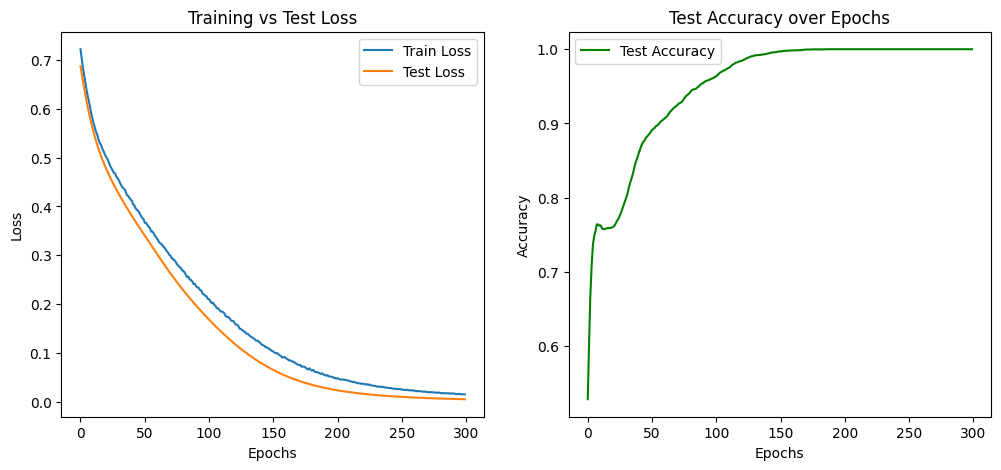


Example prediction:


KeyError: 'marital-status'

In [3]:

print("Name: TAMILARASAN K S")
print("Register No: 212223100056\n")

# =============================
# 1. Imports
# =============================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# =============================
# 2. Load Data
# =============================
df = pd.read_csv("income (1).csv")
print("Dataset shape:", df.shape)
print(df.head())

# Separate label
label_col = "income"
y = LabelEncoder().fit_transform(df[label_col])
df = df.drop(columns=[label_col])

# Identify categorical and continuous columns
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
continuous_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("\nCategorical Columns:", categorical_cols)
print("Continuous Columns:", continuous_cols)

# Encode categorical columns
cat_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    cat_encoders[col] = le

# Scale continuous columns
scaler = StandardScaler()
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

# Final numpy arrays
X_cats = df[categorical_cols].values
X_conts = df[continuous_cols].values
y = y.astype(np.int64)

# Train/test split
X_cats_train, X_cats_test, X_conts_train, X_conts_test, y_train, y_test = train_test_split(
    X_cats, X_conts, y, test_size=5000, train_size=25000, random_state=42
)

# Convert to tensors
# Convert to tensors (correct)
train_cats = torch.tensor(X_cats_train, dtype=torch.long)
train_conts = torch.tensor(X_conts_train, dtype=torch.float)  # ✅ was wrong before
train_y = torch.tensor(y_train, dtype=torch.long)

test_cats = torch.tensor(X_cats_test, dtype=torch.long)
test_conts = torch.tensor(X_conts_test, dtype=torch.float)
test_y = torch.tensor(y_test, dtype=torch.long)


# =============================
# 3. Define Model
# =============================
class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, hidden_units=50, dropout=0.4):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
        self.emb_drop = nn.Dropout(dropout)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        n_emb = sum([nf for ni, nf in emb_szs])
        self.fc1 = nn.Linear(n_emb + n_cont, hidden_units)
        self.fc2 = nn.Linear(hidden_units, out_sz)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_cats, x_conts):
        x = [emb(x_cats[:, i]) for i, emb in enumerate(self.embeds)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)

        x_conts = self.bn_cont(x_conts)
        x = torch.cat([x, x_conts], 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Embedding sizes: (unique_categories, embedding_dim)
cat_sizes = [int(df[col].nunique()) for col in categorical_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_sizes]

model = TabularModel(emb_szs, len(continuous_cols), out_sz=2)

# =============================
# 4. Training Setup
# =============================
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# =============================
# 5. Training Loop
# =============================
epochs = 300
train_losses, test_losses, test_accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(train_cats, train_conts)
    loss = criterion(y_pred, train_y)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        y_test_pred = model(test_cats, test_conts)
        test_loss = criterion(y_test_pred, test_y).item()
        test_losses.append(test_loss)

        preds = torch.argmax(y_test_pred, dim=1)
        acc = (preds == test_y).float().mean().item()
        test_accuracies.append(acc)

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}, Test Acc: {acc:.4f}")

# =============================
# 6. Graph Outputs
# =============================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label="Test Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy over Epochs")
plt.legend()

plt.show()

# =============================
# 7. Prediction Function
# =============================
def predict_new(sample_dict):
    sample_dict = {k.replace("-", "_"): v for k, v in sample_dict.items()}  # normalize keys

    cat_vals = []
    for col in categorical_cols:
        val = cat_encoders[col].transform([sample_dict[col]])[0]
        cat_vals.append(val)

    cont_vals = [sample_dict[col] for col in continuous_cols]

    x_cats = torch.tensor([cat_vals], dtype=torch.long)
    x_conts = torch.tensor([cont_vals], dtype=torch.float)

    with torch.no_grad():
        outputs = model(x_cats, x_conts)
        probs = torch.softmax(outputs, dim=1).numpy()
        pred = np.argmax(probs, axis=1)[0]

    return ("<=50K" if pred == 0 else ">50K", probs)

# =============================
# 8. Example Prediction
# =============================
print("\nExample prediction:")
sample = {
    "workclass": "Private",
    "education": "Bachelors",
    "marital_status": "Never-married",
    "occupation": "Exec-managerial",
    "relationship": "Not-in-family",
    "race": "White",
    "sex": "Male",
    "native_country": "United-States",
    "age": 30,
    "fnlwgt": 200000,
    "education_num": 13,
    "capital_gain": 0,
    "capital_loss": 0,
    "hours_per_week": 45
}
print(predict_new(sample))
